Bushra Amjad

21I-2083

SNA - Application of Node emebedding on Project Dataset

#Future Connections Predictions between Email-Eu Network using DeepWalk Embeddings



We will first import all the necessary libraries and modules:

In [15]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import lightgbm as lgbm
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

Let’s load the email network as the nodes and mutual likes between the sender and reciever as the edges

In [2]:
# load edges (or links)
with open("/content/drive/MyDrive/email-Eu-core.txt") as f:
    links = f.read().splitlines() 

len(links)

25571

We have 1005 nodes and 25,571 links. Let’s now create a dataframe of all the nodes. Every row of this dataframe represents a link formed by the nodes in the columns ‘sender’ and ‘reciever’, respectively:

In [3]:
sender = []
reciever = []
  
f = open('/content/drive/MyDrive/email-Eu-core.txt','r')
for row in f:
    row = row.split(' ')
    sender.append(row[0])
    reciever.append(int(row[1]))

email_df = pd.DataFrame({'sender': sender, 'reciever': reciever})
email_df.head()

,sender,reciever
0,0,1
1,2,3
2,2,4
3,5,6
4,5,7


We can easily represent this arrangement of emails in the form of a graph:

In [4]:
FielName="/content/drive/MyDrive/email-Eu-core.txt"
Graphtype=nx.DiGraph()
G = nx.read_edgelist(FielName, create_using=Graphtype, nodetype=int, data=(('weight',int),))
print(G)

DiGraph with 1005 nodes and 25571 edges


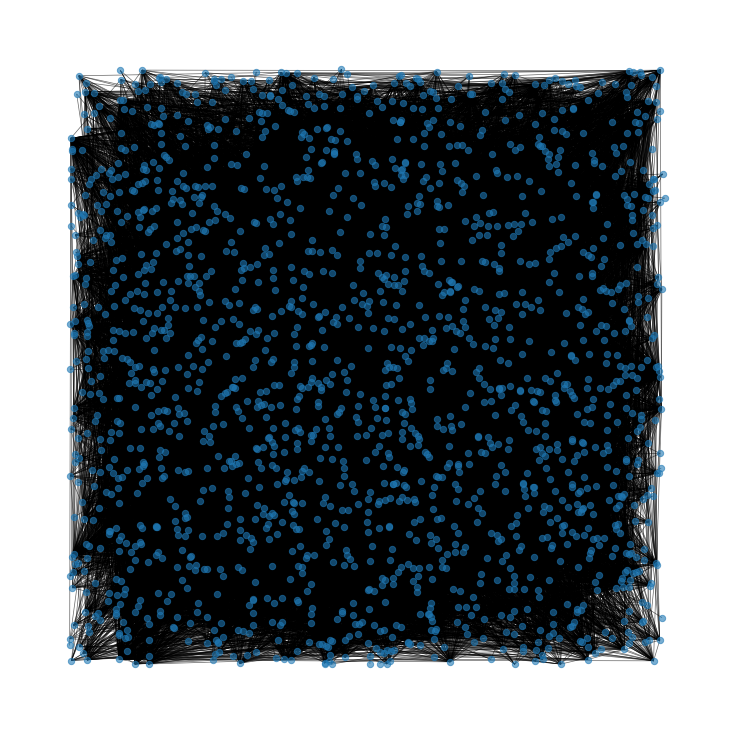

In [6]:
# create graph
G = nx.from_pandas_edgelist(email_df, "sender", "reciever")
nodes = G.nodes

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

Wow, that looks quite something. This is what we are going to deal with – a wire mesh of emails recipants (blue dots). The black lines are the links or edges connecting all the nodes to each other.

# Dataset Preparation for Model Building

We need to prepare the dataset from a graph. This dataset will have features of node pairs and the target variable would be binary in nature, indicating the presence of links (or not).

The links are denoted by the values in the matrix. 1 means there is a link between the node pair and 0 means there is a link between the node pair.

In [7]:
email_df_pos_link = email_df.copy()
email_df_pos_link['link'] = 1
email_df_pos_link

,sender,reciever,link
0,0,1,1
1,2,3,1
2,2,4,1
3,5,6,1
4,5,7,1
...,...,...,...
25566,420,143,1
25567,174,859,1
25568,440,460,1
25569,52,786,1


We will use this property of the adjacency matrix to find all the unconnected node pairs from the original graph G:

In [8]:
# combine all nodes in a list
node_list = sender + reciever

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)
adj_G.shape

(1859, 1859)

Let’s search the diagonal values for zero:

In [9]:
all_unconnected_pairs = []

offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
        if adj_G[i,j] == 0:
          all_unconnected_pairs.append([node_list[i],node_list[j]])

  offset = offset + 1

100%|██████████| 1859/1859 [00:03<00:00, 479.54it/s] 


Here’s how many unconnected node pairs we have in our dataset:

In [10]:
len(all_unconnected_pairs)

1701440

We have 1,701,440 unconnected pairs. These node pairs will act as negative samples during the training of the link prediction model. Let’s keep these pairs in a dataframe:

In [11]:
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

email_df_neg_link = pd.DataFrame({'sender':node_1_unlinked, 'reciever':node_2_unlinked})

# add target variable 'link'
email_df_neg_link['link'] = 0
email_df_neg_link

,sender,reciever,link
0,0,2,0
1,0,5,0
2,0,8,0
3,0,10,0
4,0,12,0
...,...,...,...
1701435,1001,1003,0
1701436,1001,1004,0
1701437,1002,1003,0
1701438,1002,1004,0


Merge both positive and negative samples and shuffle it

In [12]:
email_df_link = [email_df_pos_link , email_df_neg_link]
email_df_link = pd.concat(email_df_link)
email_df_link = email_df_link.sample(frac=1).reset_index(drop=True)
email_df_link

,sender,reciever,link
0,227,369,0
1,215,118,0
2,618,922,0
3,768,849,0
4,750,317,0
...,...,...,...
1727006,748,911,0
1727007,245,232,0
1727008,659,993,0
1727009,116,617,0


In [13]:
email_df_link['link'].value_counts()

0    1701440
1      25571
Name: link, dtype: int64

We have 1,701,440 negative samples and 25571 positive samples. It turns out that this is highly imbalanced data. In the next section, we will extract features for all these node pairs.

# Node Embedding

Ready to walk the graph?

Here, I have defined a function that will take a node and length of the path to be traversed as inputs. It will walk through the connected nodes from the specified input node in a random fashion. Finally, it will return the sequence of traversed nodes:


In [16]:
def get_randomwalk(node, path_length):
    random_walk = [node]
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break

        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk

Here, I have specified the length to traverse as 10. You can change this number and play around with it. Next, we will capture the random walks for all the nodes in our dataset:

In [17]:
all_nodes = list(G.nodes())
random_walks = []

for n in tqdm(all_nodes):
    for i in range(5):
        random_walks.append(get_randomwalk(n,10))

random_walks_str = []
for i in range(0, len(random_walks)):
  numbers = list(map(str, random_walks[i]))
  random_walks_str.append(numbers)

100%|██████████| 1859/1859 [00:00<00:00, 2256.46it/s]


In [18]:
len(random_walks_str)

9295

So, with the traverse length set to 10, we have got 9,295 random walk sequences of nodes. We can use these sequences as inputs to a skip-gram model and extract the weight learned by the model (which are nothing but the node embeddings).

In [19]:
random_walks_str

[['0', '221', '21', '260', '10', '306', '93', '41', '201', '206'],
 ['0', '283', '209', '58', '5', '154', '155', '87', '105', '441'],
 ['0', '377', '393', '607', '490', '365', '128', '118', '84', '166'],
 ['0', '215', '812', '859', '254', '144', '121', '333', '438', '417'],
 ['0', '297', '177', '229', '29', '169', '115', '548', '497', '581'],
 ['1', '74', '107', '114', '106', '155', '495', '371', '490', '410'],
 ['1', '310', '272', '322', '15', '541', '181', '150', '368', '82'],
 ['1', '52', '128', '388', '387', '393', '145', '422', '513', '84'],
 ['1', '377', '133', '172', '212', '371', '81', '105', '5', '171'],
 ['1', '84', '86', '484', '129', '563', '493', '65', '324', '565'],
 ['2', '2', '305', '211', '845', '699', '9', '823', '823', '707'],
 ['2', '3', '166', '303', '254', '651', '420', '404', '121', '540'],
 ['2', '812', '59', '54', '56', '412', '63', '131', '209', '56'],
 ['2', '137', '255', '371', '371', '405', '160', '150', '181', '384'],
 ['2', '137', '6', '379', '394', '160'

# DeepWalk

Next, we will train the skip-gram model with the random walks:

In [20]:
embeddings = Word2Vec(window = 4, sg = 1, hs = 0, negative = 10, alpha=0.03, 
                      min_alpha=0.0007,seed = 14)

embeddings.build_vocab(random_walks_str, progress_per=2)
embeddings.train(random_walks_str, total_examples = embeddings.corpus_count, epochs=20, report_delay=1)

(1685073, 1800880)

Now, every node in the graph is represented by a fixed length (100) vector. Let’s find out the most similar recipants to “1”:

In [21]:
embeddings.wv.similar_by_word("1")

[('775', 0.5984764695167542),
 ('979', 0.5879145860671997),
 ('946', 0.5278198719024658),
 ('941', 0.5096030235290527),
 ('782', 0.49928590655326843),
 ('911', 0.49908679723739624),
 ('629', 0.48518335819244385),
 ('920', 0.47664588689804077),
 ('759', 0.47438913583755493),
 ('454', 0.4737823009490967)]

We will now view the embeddings in the form of pandas dataframe

In [22]:
ordered_vocab = [(term, voc.index, voc.count) for term, voc in embeddings.wv.vocab.items()]
ordered_vocab = sorted(ordered_vocab, key=lambda k: k[2])
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)
word_vectors = pd.DataFrame(embeddings.wv.syn0[term_indices, :], index=ordered_terms)
word_vectors

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  after removing the cwd from sys.path.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
583,0.325175,0.539424,0.232630,-0.072600,-0.133885,-0.255407,-0.139403,0.039045,-0.237168,-0.115044,...,-0.197616,0.085863,-0.330570,0.316935,-0.060502,-0.008239,0.334171,0.133231,-0.063751,0.411784
774,0.214104,0.732462,-0.288789,-0.188567,-0.268729,-0.435239,0.168672,0.410614,0.040957,-0.257744,...,0.058037,0.016438,0.150063,-0.036606,0.117893,-0.137915,-0.321784,0.115658,-0.047985,0.254748
792,0.116955,0.306601,0.057231,-0.176522,0.068032,-0.197826,0.006271,0.156757,0.104068,-0.193728,...,0.119977,0.028181,-0.274795,0.342589,0.103235,-0.283897,0.289569,0.466930,-0.007624,0.153304
827,-0.048088,0.356970,-0.159920,0.566616,0.137544,0.028051,-0.246250,0.154523,0.420274,0.089496,...,0.085842,-0.077591,0.029773,0.447236,0.227626,-0.036956,0.542824,0.276921,-0.171756,0.095197
830,0.017190,0.370206,0.055769,0.491374,0.065834,-0.113227,-0.244870,0.186417,0.335222,0.037629,...,0.027270,-0.155315,-0.118906,0.147345,0.278153,-0.123173,0.271990,0.258815,0.162035,0.225920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,-0.153174,0.727443,0.340526,-0.071901,0.003250,-0.182202,-0.310932,0.343042,0.153841,-0.174581,...,-0.307437,-0.267373,-0.342065,0.268881,-0.062911,0.363811,0.415907,0.266490,-0.174015,-0.146577
121,0.169621,0.026230,-0.362742,-0.187407,0.335776,-0.213888,0.259478,0.357459,0.318907,-0.354576,...,-0.264333,0.126610,-0.034898,0.635832,0.154710,0.019595,0.197152,-0.094225,0.325048,0.406216
107,0.336135,0.345030,-0.203321,0.000678,-0.024502,-0.177971,0.060157,0.475139,0.086633,-0.547354,...,-0.032119,0.367234,0.101367,0.073905,0.012981,-0.152319,-0.217776,0.536163,0.067608,0.274727
62,0.129283,0.215503,-0.171874,-0.097821,-0.236370,0.014753,-0.197581,0.367737,0.055492,-0.702336,...,-0.015204,-0.090121,-0.303641,0.154227,0.188770,-0.307899,0.476613,0.051165,-0.001196,0.396803


Now, I want to see how well our node embeddings capture the similarity between different nodes. I will get the nodes from the graph and will plot them on a 2-dimensional space:

Below I have defined a function that will plot the vectors of the selected nodes in a 2-dimensional space:



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


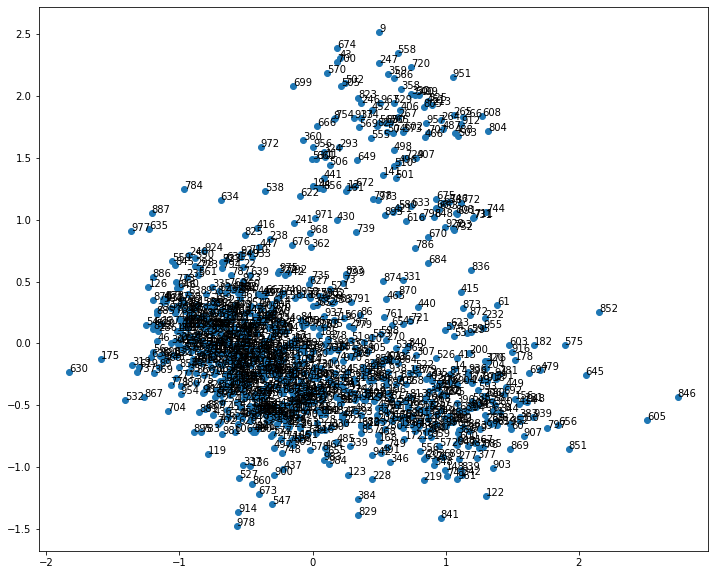

In [23]:
node_idx = range(1,986)
node_idx_str = []
for i in node_idx:
  node_idx_str.append(str(i))

def plot_nodes(word_list):
    new_list = []
    for i in word_list:
        if i in embeddings:
          new_list.append(i)

    X = embeddings[new_list]
    
    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
  
    plt.figure(figsize=(12,10))
    
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])
    
    for i, word in enumerate(new_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
        
    plt.show()
  
plot_nodes(node_idx_str)

This is why DeepWalk embeddings are so useful. We can use these embeddings to solve multiple graph-related problems such as link prediction, node classification, question-answering system and many more.

Next, we will apply the trained node2vec model on each and every node pair in the dataframe ‘email_df_link’. To compute the features of a pair or an edge, we will add up the features of the nodes in that pair:

In [24]:
x = [(embeddings[str(i)] + embeddings[str(j)]) for i,j in zip(email_df_link['reciever'], 
                                                              email_df_link['reciever'])]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


To validate the performance of our model, we should split our data into two parts – one for training the model and the other to test the model’s performance:

In [25]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), email_df_link['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

In [26]:
train_data = lgbm.Dataset(xtrain, ytrain)
test_data = lgbm.Dataset(xtest, ytest)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=20)

[1]	valid_0's auc: 0.705105
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's auc: 0.714496
[3]	valid_0's auc: 0.722348
[4]	valid_0's auc: 0.72687
[5]	valid_0's auc: 0.731718
[6]	valid_0's auc: 0.736137
[7]	valid_0's auc: 0.739624
[8]	valid_0's auc: 0.743618
[9]	valid_0's auc: 0.74732
[10]	valid_0's auc: 0.750964
[11]	valid_0's auc: 0.754153
[12]	valid_0's auc: 0.757238
[13]	valid_0's auc: 0.760224
[14]	valid_0's auc: 0.76317
[15]	valid_0's auc: 0.76559
[16]	valid_0's auc: 0.767849
[17]	valid_0's auc: 0.770279
[18]	valid_0's auc: 0.772058
[19]	valid_0's auc: 0.774093
[20]	valid_0's auc: 0.775827
[21]	valid_0's auc: 0.777438
[22]	valid_0's auc: 0.778875
[23]	valid_0's auc: 0.780481
[24]	valid_0's auc: 0.781989
[25]	valid_0's auc: 0.783317
[26]	valid_0's auc: 0.784628
[27]	valid_0's auc: 0.785804
[28]	valid_0's auc: 0.786894
[29]	valid_0's auc: 0.788049
[30]	valid_0's auc: 0.789008
[31]	valid_0's auc: 0.789784
[32]	valid_0's auc: 0.790555
[33]	valid_0's auc: 0.7

We get a score of 0.803 using a LightGBM model.